## Импорт библиотек

In [1]:
import zipfile # Библиотека для работы с zip архивами
import os      # Библиотека для работы с фаловой системой 
from shutil import copy
from tqdm import tqdm
from collections import Counter

from google.colab import drive # Модуль для работы с Google Disk

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms


import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from PIL import Image

## Загрузка данных

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Прописываем путь к файлу с архивом
zip_file = "drive/My Drive/Deep Learning projects/Detection_Yolo_v1/archive.zip"

# Распаковываем архив
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

# Просмотр результата разархивации
print(os.listdir())

['.config', 'generate_csv.py', '8examples.csv', 'get_data', 'test.csv', '100examples.csv', 'labels', 'drive', 'images', 'train.csv', 'sample_data']


In [4]:
img_dir = './images'
labels_dir = './labels'

## Датасет

Пропишем кастомный класс датасета на ***Pytorch***

Изображения будут разделены на 49 прямоугольных ячеек  

Для визуализации еще не обученных данных, сделаем флаг ***visual***, благодаря которому класс будет возвращать изображение и координаты объектов на изображении

In [5]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, labels_dir, data_csv, classes=20, boxes=2, cells=7, transform=None, visual=None):
        super(torch.utils.data.Dataset).__init__()
        
        self.img_dir = img_dir
        self.labels_dir = labels_dir
        self.csv = pd.read_csv(data_csv)

        self.classes = classes
        self.boxes = boxes
        self.cells = cells
        
        self.transform = transform
        self.visual = visual

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        img_name = self.csv.iloc[idx, 0]
        label_name = self.csv.iloc[idx, 1]

        img_path = os.path.join(self.img_dir, img_name)
        label_path = os.path.join(self.labels_dir, label_name)

        boxes = []
        with open(label_path) as f:
            for label in f.readlines():
                class_label, x, y, width, lenght = [float(x) if float(x) != int(float(x)) else int(x)
                                                     for x in label.replace("\n", "").split()]
                boxes.append([class_label, x, y, width, lenght])

        
        # img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # img = img.astype(np.float32)
        # img = img/255.0
        img = Image.open(img_path)
        if self.visual:
            return {'img': img,
                    'label': boxes}

        boxes = torch.tensor(boxes)

        if self.transform:
            img, boxes = self.transform(img, boxes)

        label_matrix = torch.zeros((self.cells, self.cells, self.classes + 5 * self.boxes))
        for box in boxes:
            class_label, x, y, width, lenght = box.tolist()
            class_label = int(class_label)

            row, column = int(self.cells * y), int(self.cells * x) # определим координаты ячейки, где находится центр объекта
            x_cell, y_cell = self.cells * x - column, self.cells * y - row # найдем координаты центра объекта в конкретной ячейке
            width_cell, lenght_cell = self.cells * width, self.cells * lenght # измерим длину и ширину объекта в ячейках

            if label_matrix[column, row, 20] == 0:

                label_matrix[column, row, 20] = 1
                label_matrix[column, row, 21:25] = torch.tensor([x_cell, y_cell, width_cell, lenght_cell])
                label_matrix[column, row, class_label] = 1
        

        
        return {"img": img,
                "label": label_matrix}

На выходе ***label_matrix*** имеет 30 чисел (столько же будет на выходе модели ***YOLO***) для каждой ячейки. Первые 20 чисел это классы, далее метка, есть ли центр объекта в этой ячейке и после координаты объекта (координаты центра, ширина, длина). Остальные значения будут равны 0, в обучение они не понадобятся.  

Важно! Координаты объекта надо выразить через ячейки, на которые делится изображение, потому что наша модель будет обучаться через рамки, которые задаются внутри ячеек (т.е. координаты обучаемых рамок выражены через ячейки)

In [6]:
class Compose(object):
    def __init__(self, transform):
        self.transform = transform
    
    def __call__(self, images, boxes):
        for t in self.transform:
            images, boxes = t(images), boxes
        
        return images, boxes

Изменим размер изображения (классическая ***YOLOv1*** обучалась на картинках размером *448х448*)

In [7]:
transform = Compose([transforms.Resize((448, 448)),
                      transforms.ToTensor()])

Пропустим через наш класс 8 изображений

In [ ]:
visual_dataset = MyDataset(img_dir=img_dir, labels_dir=labels_dir, data_csv='8examples.csv', visual=True)

Визуализируем данные, чтобы удостовериться, что наш датасет считывает данные нормально

In [ ]:
def plot_img(data, NCOLS:int):
    random_idx = np.random.choice(len(data), NCOLS, replace=False)
    fig, ax = plt.subplots(nrows=1, ncols=NCOLS, figsize=(15,18))

    for i in range(NCOLS):
        img, boxes = data[random_idx[i]]['img'], data[random_idx[i]]['label']
        h, w, _ = img.shape

        ax[i].imshow(img)
        ax[i].axis('off')

        for box in boxes:
            box = box[1:]
        
            upper_left_x = box[0] - box[2] / 2
            upper_left_y = box[1] - box[3] / 2
        
            rect = patches.Rectangle(
                    (upper_left_x * w, upper_left_y * h),
                    box[2] * w,
                    box[3] * h,
                    linewidth=1,
                    edgecolor="r",
                    facecolor="none",
                )
            ax[i].add_patch(rect)
        
    plt.show()
    

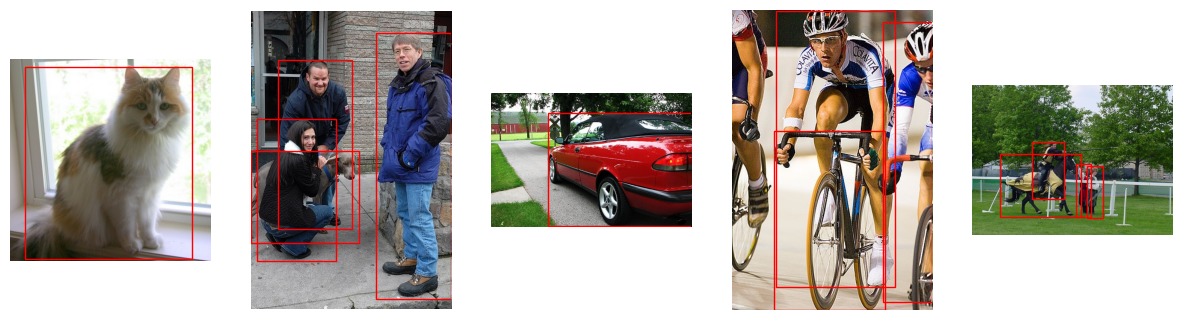

In [ ]:
plot_img(visual_dataset, 5)

Все в порядке

## Создание модели

Напишем своими руками модель ***YOLOv1***, архитектура, которой представлена ниже и была взята из оригинальной статьи https://arxiv.org/pdf/1506.02640.pdf

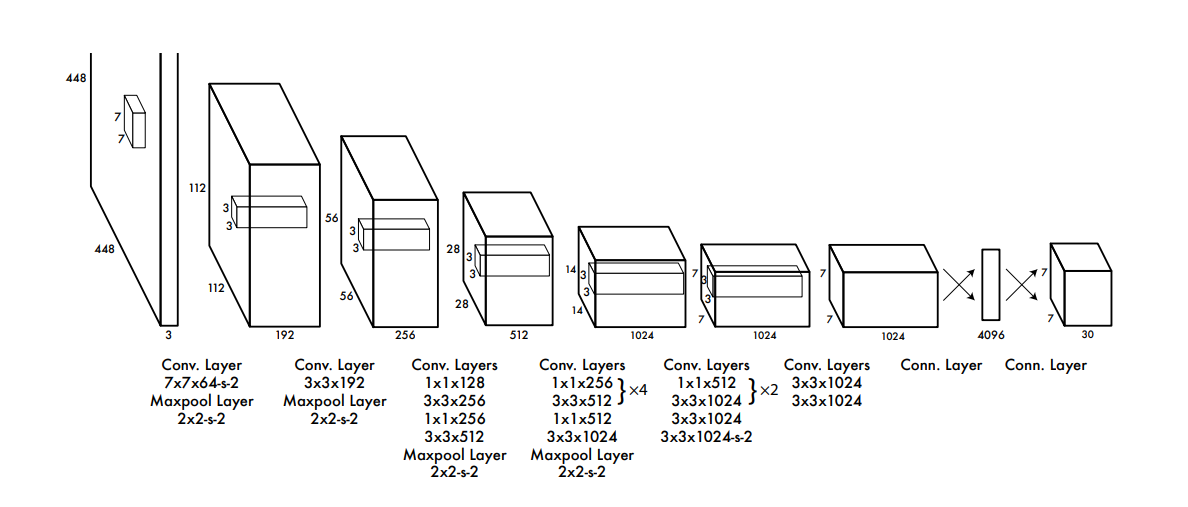

### CNN Block

Если x[0] == "c", то применяется слой конволюшена, где:

*   x[1] - размер фильтра
*   x[2] - кол-во выходных каналов

*   x[3] - страйд
*   x[4] - паддинг

Если x[0] == "m", то применяется Maxpool, где:

*   x[1] - размер ядра
*   x[2] - страйд

Если x[0] == "f", то применяется полносвязный линейный слой, где:

*   x[1] - кол-во параметров на входе
*   x[2] - кол-во параметров на выходе











In [8]:
architecture_config = [
    ('c', 7, 64, 2, 3),
    ('m', 2, 2),

    ('c', 3, 192, 1, 1),
    ('m', 2, 2),

    ('c', 1, 128, 1, 0),
    ('c', 3, 256, 1, 1),
    ('c', 1, 256, 1, 0),
    ('c', 3, 512, 1, 1),
    ('m', 2, 2),

    ('c', 1, 256, 1, 0),
    ('c', 3, 512, 1, 1),
    ('c', 1, 256, 1, 0),
    ('c', 3, 512, 1, 1),
    ('c', 1, 256, 1, 0),
    ('c', 3, 512, 1, 1),
    ('c', 1, 256, 1, 0),
    ('c', 3, 512, 1, 1),
    ('c', 1, 512, 1, 0), 
    ('c', 3, 1024, 1, 1),
    ('m', 2, 2),

    ('c', 1, 512, 1, 0),
    ('c', 3, 1024, 1, 1),
    ('c', 1, 512, 1, 0),
    ('c', 3, 1024, 1, 1),
    ('c', 3, 1024, 1, 1),
    ('c', 3, 1024, 2, 1),

    ('c', 3, 1024, 1, 1),
    ('c', 3, 1024, 1, 1),

    ('f', 1024*7*7, 512),
    ('f', 512, 7*7*30)

]

В оригинальной статье изображение делилось на 49 (7*7) прямоугольных ячеек. В каждой ячейке будет размещаться 2 рамки, которые в ходе обучения будут менять свои границы. Каждая рамка характеризуется 5 числами. Четыре из них это границы рамки внутри ячейки, а одно число это вероятность нахождения объекта в рамке. Поэтому для каждой ячейки в конце выводится 30 значений (20 из которых это классы, на которых обучается модель и по 5 значений для каждой рамки)

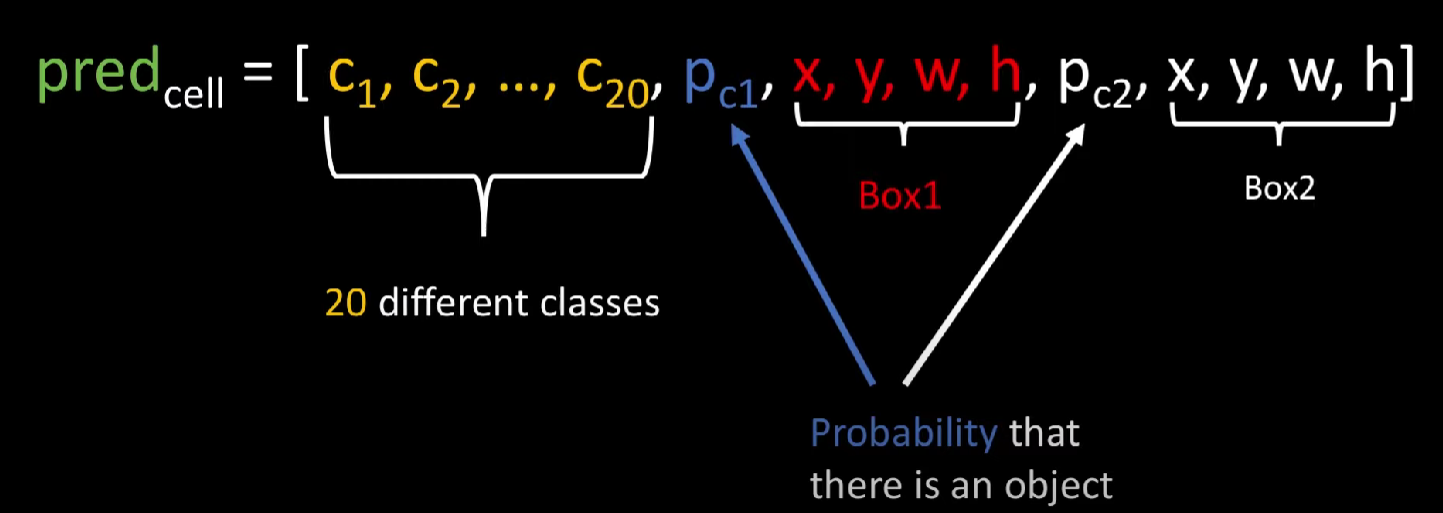

In [9]:
class CNNBlock(nn.Module):
    def __init__(self, in_c, out_c, kernel,  s, p):
        super().__init__()
        
        self.conv = nn.Conv2d(in_channels=in_c,
                              out_channels=out_c,
                              kernel_size=kernel,
                              stride=s,
                              padding=p)
        self.norm = nn.BatchNorm2d(out_c)
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):
        out = self.leaky_relu(self.norm(self.conv(x)))
        return out
  

### YOLOv1

In [10]:
class YOLOv1(nn.Module):
    def __init__(self, in_c=3, **kwargs):
        super().__init__()
        
        self.in_channels = in_c
        self.arch_config = architecture_config
        self.darknet = self._darknet()

    def forward(self, x):
        out = self.darknet(x)
        return out

    def _darknet(self, **kwargs):
        layers = []

        for x in self.arch_config:
            if x[0] == 'c':
                layers += [CNNBlock(in_c=self.in_channels, 
                                       out_c=x[2],
                                       kernel=x[1],
                                       s=x[3],
                                       p=x[4])]
                self.in_channels = x[2]
            
            elif x[0] == 'm':
                layers += [nn.MaxPool2d(kernel_size=x[1],
                                       stride=x[2])]

            elif x[0] == 'f':
                layers += [nn.Flatten(),
                           nn.Linear(in_features=x[1], out_features=x[2]),
                           nn.LeakyReLU()]
                    
        return nn.Sequential(*layers)

In [ ]:
train = torch.rand((2, 3, 448, 448))

In [ ]:
net = YOLOv1()
net.forward(x = train)

torch.Size([2, 1470])

In [ ]:
# ed = torch.rand((1,1470))
# pred = ed.reshape(-1, 7,7,30)
# target = torch.rand((1,7 , 7, 30))
# pred.shape

torch.Size([1, 7, 7, 30])

## Функция потерь

### IoU

Каждый объект задан 4 координатами (x, y, w, h), где x, y - это координаты центра объекта, а w, h - длина и ширина объекта соответственно.

Будем использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$


In [11]:
def IoU(boxes_preds, boxes_labels):

    b_p_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
    b_p_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
    b_p_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
    b_p_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2

    b_l_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
    b_l_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
    b_l_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
    b_l_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    x1 = torch.max(b_p_x1, b_l_x1)
    x2 = torch.min(b_p_x2, b_l_x2)
    y1 = torch.max(b_p_y1, b_l_y1)
    y2 = torch.min(b_p_y2, b_l_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box_p = abs((b_p_x2 - b_p_x1) * (b_p_y2 - b_p_y1))
    box_l = abs((b_l_x2 - b_l_x1) * (b_l_y2 - b_l_y1))

    return intersection / (box_l + box_p - intersection + 1e-6) 

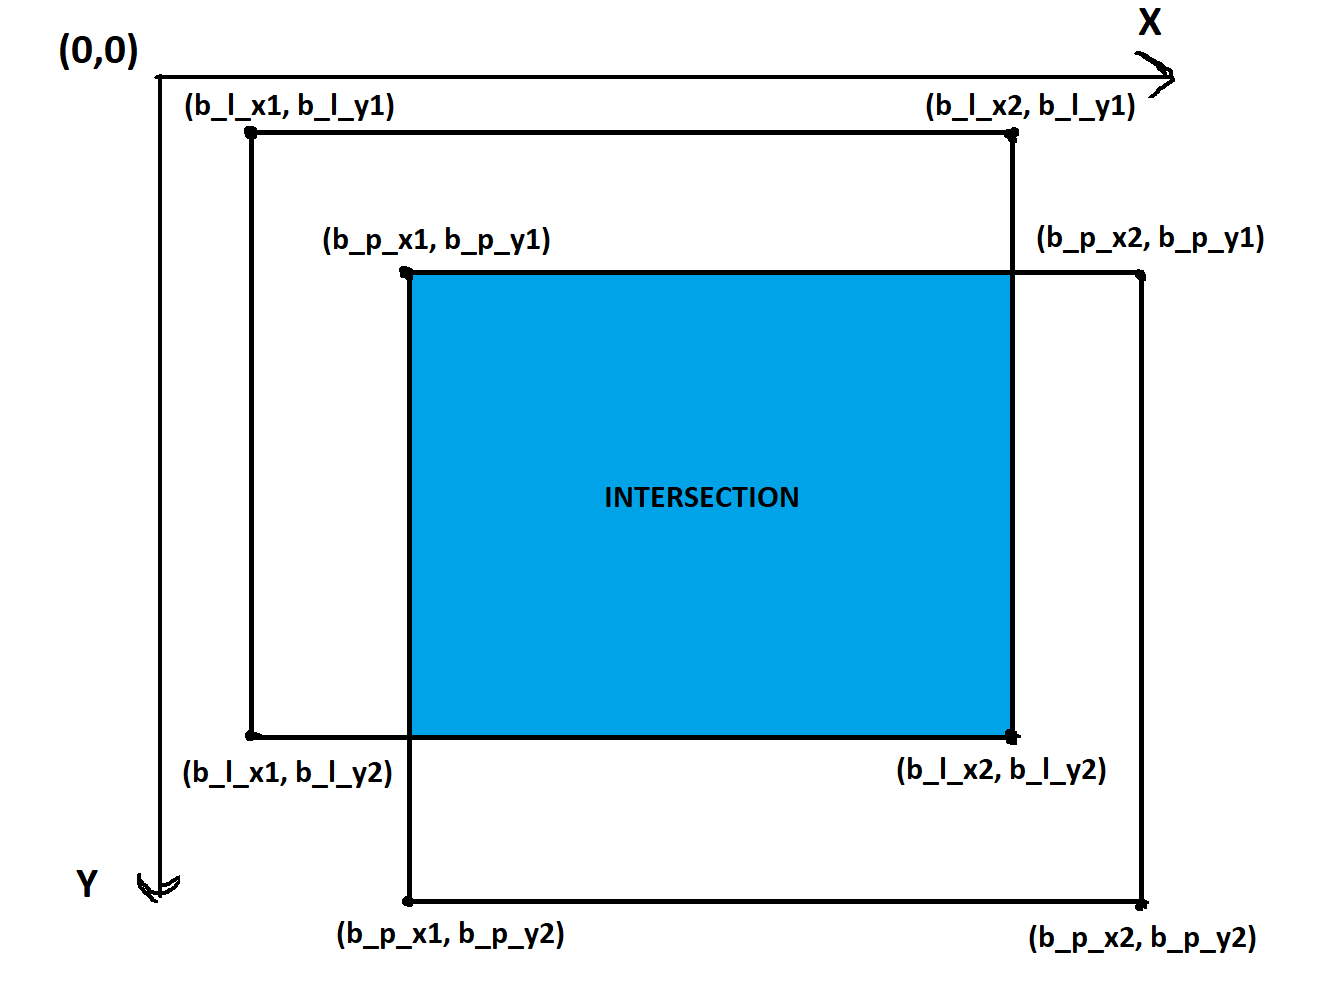

### YoloLoss

Так выглядит функция потерь из оригинальной статьи

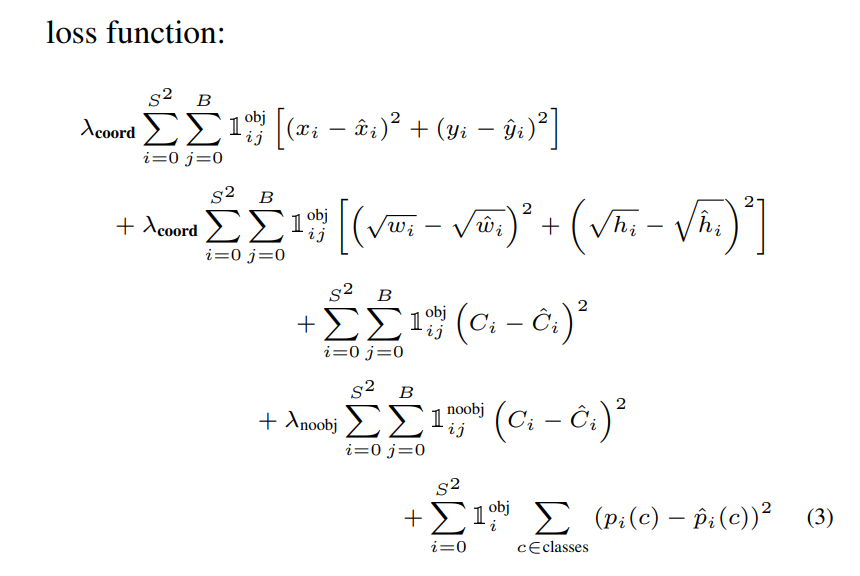

Реализуем ее

In [53]:
class YoloLoss(nn.Module):
    def __init__(self, classes=20, boxes=2, cells=7):
        super().__init__()

        self.lambda_coord = 5
        self.lambda_noobj = 0.5

        self.classes = classes
        self.boxes = boxes
        self.cells = cells

        self.mse = nn.MSELoss(reduction='sum') # по умолчанию берется среднее, нам необходимо просуммировать

    def forward(self, preds, labels):
        # preds.shape ---> (batch_size, cells^2*(classes+5*boxes)
        preds = preds.reshape(-1, self.cells, self.cells, self.classes + self.boxes*5)
        # preds.shape ---> (batch_size, cells, cells, classes+5*boxes)
        iou_b1 = IoU(preds[..., 21:25], labels[..., 21:25]) 
        iou_b2 = IoU(preds[..., 26:30], labels[..., 21:25])
        # 0:20 - классы, 20 - вероятность принадлежности классу 1 первой рамки, 21:25 - координаты рамки, 25 - вероятность принадлежности классу 1 второй рамки, 26:30 - координаты рамки 
        iou = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        best_iou, best_box = torch.max(iou, dim=0)
        exist_box = labels[..., 20].unsqueeze(3) # метка, что в ячейке есть центр объекта

        # BOX_LOSS
        #-----------------------------------------------------------------------
        
        box_preds = exist_box * (best_box * preds[..., 26:30] + (1 - best_box) * preds[..., 21:25])
        box_labels = exist_box * labels[..., 21:25]

        box_preds[..., 2:4] = torch.sign(box_preds[..., 2:4]) * torch.sqrt(torch.abs(box_preds[..., 2:4] + 1e-6))
        box_labels[..., 2:4] = torch.sqrt(box_labels[..., 2:4]) 
        # берем квадратный корень из высоты и длины рамки 

        box_loss = self.mse(
            torch.flatten(box_preds, end_dim=-2),
            torch.flatten(box_labels, end_dim=-2)
        )

        # OBJECT_LOSS
        #-----------------------------------------------------------------------
        
        pred_box = (best_box * preds[..., 25:26] + (1 - best_box) * preds[..., 20:21])

        object_loss = self.mse(torch.flatten(exist_box * pred_box),
                               torch.flatten(exist_box * labels[..., 20:21]))
        
        # NO_OBJECT_LOSS
        #-----------------------------------------------------------------------

        no_object_loss = self.mse(torch.flatten((1 - exist_box) * preds[..., 20:21], start_dim=1),
                                  torch.flatten((1 - exist_box) * labels[..., 20:21], start_dim=1))
        
        no_object_loss += self.mse(torch.flatten((1 - exist_box) * preds[..., 25:26], start_dim=1),
                                  torch.flatten((1 - exist_box) * labels[..., 20:21], start_dim=1))

        # CLASS_LOSS
        #-----------------------------------------------------------------------

        classes_loss = self.mse(torch.flatten(exist_box * preds[..., :20], end_dim=-2),
                                torch.flatten(exist_box * labels[..., :20], end_dim=-2))
        
        # SUMMARY
        #-----------------------------------------------------------------------
        loss = (self.lambda_coord * box_loss +
                object_loss + 
                self.lambda_noobj * no_object_loss +
                classes_loss)
        
        return loss

## Обучение

### Non Maximum Suppression

Этот алгоритм позволит выбрать самую лучшую рамку для каждого объекта в изображении

Для начала мы выбираем рамку, в которой с большей вероятностью есть объект, удаляем его из списка рамок и добавляем в список лучших рамок (где для каждого класса будет своя рамка). Оставаться же в общем списке будут рамки другого класса (другой объект) или рамки того же класса, но с низкой ***IoU*** (т.е. подразумевается, что на изображении могут быть два объекта одного класса)

In [13]:
def nms(boxes, iou_threshold, threshold):
    # box --> [class, prob_of_obj, x, y, w, h]
    best_boxes = []
    boxes = [box for box in boxes if box[1] > threshold]
    boxes = sorted(boxes, key=lambda x: x[1], reverse=True)
    
    while boxes:
        best_box = boxes.pop(0)
        boxes = [box for box in boxes 
                     if box[0] != best_box[0]
                     or IoU(torch.tensor(box[2:]), torch.tensor(best_box[2:])) < iou_threshold]

        best_boxes.append(best_box)

    return best_boxes

В классе датасета мы изменили координаты рамок (выразили их через ячейки, на которые поделили изображение). Для дальнейшего отображения необходимо обратно преобразовать эти координаты относительно размеров изображения

In [14]:
def convert_cellboxes(pred, cells=7, classes=20, boxes=2):
    pred = pred.to('cpu')
    batch_size = pred.shape[0]
    pred = pred.reshape(batch_size, cells, cells, classes + boxes * 5)
    box1 = pred[..., 21:25]
    box2 = pred[..., 26:30]

    scores = torch.cat((pred[..., 20].unsqueeze(0), pred[..., 25].unsqueeze(0)), dim=0)
    best_box = scores.argmax(0).unsqueeze(-1) # выбираем индекс лучшей рамки из двух для каждой ячейки
    best_boxes = (1 - best_box) * box1 + best_box * box2  # отбираем лучшие рамки для каждой ячейки
    
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / cells * (best_boxes[..., :1] + cell_indices)
    y = 1 / cells * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_h = 1 / cells * best_boxes[..., 2:4]
    
    pred_class = pred[..., :20].argmax(-1).unsqueeze(-1)
    best_prob = torch.max(pred[..., 20], pred[..., 25]).unsqueeze(-1)
    converted_boxes = torch.cat((x, y, w_h), dim=-1)

    converted_pred = torch.cat((pred_class, best_prob, converted_boxes), dim=-1)

    return converted_pred # shape [batch_size, cells, cells, 30] --> [batch_size, cells, cells, 6],
                          # то есть оставили метку класса и для каждой ячейки выбрали лучшую рамку

def cellboxes_to_boxes(target, cells=7):
    all_boxes = []
    conv_target = convert_cellboxes(target).reshape(target.shape[0], cells * cells, -1)
    conv_target[..., 0] = conv_target[..., 0].long()
    
    for idx in range(target.shape[0]):
        boxes = []
        for cell in range(cells * cells):
            boxes.append([x.item() for x in conv_target[idx, cell, :]])
        
        all_boxes.append(boxes)
    
    return all_boxes # Сохраняем в список все рамки каждого изображения

Список на выходе функции ***cellboxes_to_boxes*** будет передаваться на вход функции ***nms***

### Mean Average Precision

Проиндексируем рамки каждого изображения. То есть на вход подавались рамки [[***class***, ***prob_of_obj***, ***x***, ***y***, ***w***, ***h***], [], []...], а на выходе будут [[***image_idx***, ***class***, ***prob_of_obj***, ***x***, ***y***, ***w***, ***h***], [], []...]

In [15]:
def get_boxes(data, model, iou_threshold, prob_threshold, DEVICE):
    all_pred_boxes = []
    all_true_boxes = []

    model.eval() # ставим в режим предсказания
    train_idx = 0

    for sample in data:
        
        x = sample['img'].to(DEVICE)
        label = sample['label'].to(DEVICE)

        with torch.no_grad():
            pred = model(x)

        batch_size = x.shape[0]
        pred_boxes = cellboxes_to_boxes(pred)
        true_boxes = cellboxes_to_boxes(label)

        for i in range(batch_size):
            nms_boxes = nms(pred_boxes[i], iou_threshold, prob_threshold)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)
            
            for box in true_boxes[i]:
                if box[1] > prob_threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1
      
    model.train() # обратно преключаем в режим обучения

    return all_pred_boxes, all_true_boxes

Теперь напишем метрику, которая считаешь ***precision*** и ***recall***, а потом вычисляет площадь под графиком ***precision-recall*** кривой

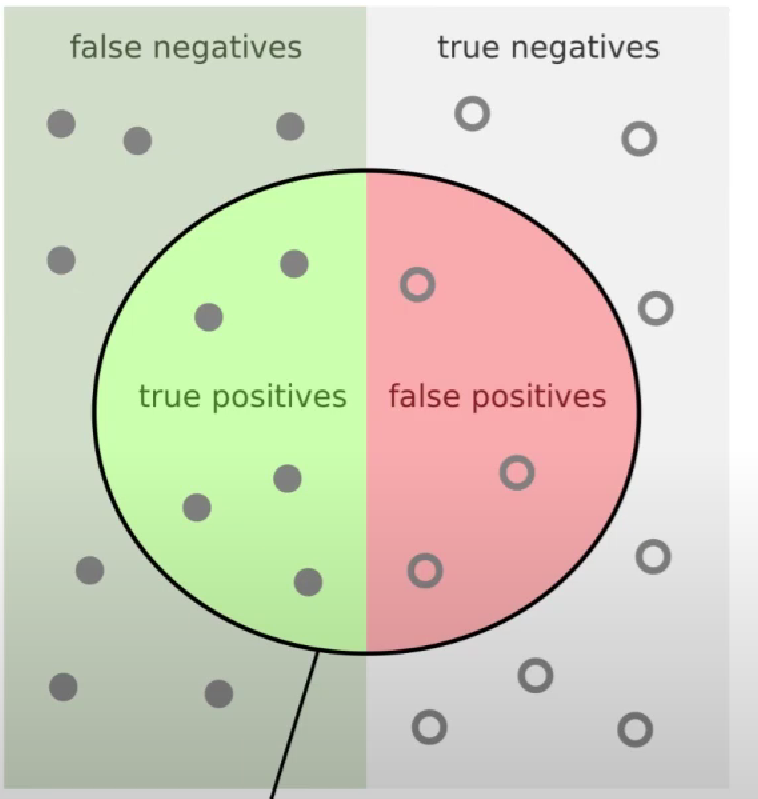

In [46]:
def mean_average_precision(pred_boxes, true_boxes, iou_threshold, num_classes=20):
    average_precision = []
    eps = 1e-6
  
    for c in range(num_classes):
        detections = []
        ground_truths = []

        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)
        
        for box in true_boxes:
            if box[1] == c:
                ground_truths.append(box)
        
        amount_boxes = Counter([x[0] for x in ground_truths]) # amount_bboxes = {img_idx_1: num(img_idx_1), img_idx_2:num(img_idx_2)}
                                                              # amount_bboxes = {0: 4, 1:2}

        for k, v in amount_boxes.items():
            amount_boxes[k] = torch.zeros(v) # amount_bboxes = {0:torch.tensor[0,0,0,0], 1:torch.tensor[0,0]}

        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections))) # Верно предсказанные рамки
        FP = torch.zeros((len(detections))) # Предсказанные рамки, которые не показывают объект
        totat_true_boxes = len(ground_truths)

        if totat_true_boxes == 0:
            continue

        for det_idx, detection in enumerate(detections):
            ground_truths_img = [x for x in ground_truths if x[0] == detection[0]] # В этом списке храним настоящие рамки одного изображения

            len_g_t_img = len(ground_truths_img)
            best_iou = 0

            for idx, img in enumerate(ground_truths_img): # Прогоняем каждую настоящую рамку и высчитываем IoU с предсказанной рамкой
                iou = IoU(torch.tensor(detection[3:]),
                          torch.tensor(img[3:]))
                
                if iou > best_iou: # Лучшую Iou сохраняем, а также сохраняем индекс настоящей рамки, с которой самый высокий IoU у предсказания
                    best_iou = iou
                    best_idx = idx
                
            if best_iou > iou_threshold:
                if amount_boxes[detection[0]][best_idx] == 0:
                    TP[det_idx] = 1
                    amount_boxes[detection[0]][best_idx] = 1
                else:
                    FP[det_idx] = 1
            else:
                FP[det_idx] = 1
        
        TP_cumsum = torch.cumsum(TP, dim=0) # [1, 0, 1, 1, 0] --> [1, 1, 2, 3, 3]
        FP_cumsum = torch.cumsum(FP, dim=0)
        
        recalls = TP_cumsum / (totat_true_boxes + eps) # Отношение правильно предсказанных рамок ко всем рамкам на изображении
        recalls = torch.cat((torch.tensor([0]), recalls))

        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + eps)) # Отношение правильно предсказанных рамок ко всем предсказанным рамкам на изображении
        precisions = torch.cat((torch.tensor([1]), precisions))
        average_precision.append(torch.trapz(precisions, recalls)) # высчитывает площадь под графиком precision-recall кривой

    return sum(average_precision) / len(average_precision)

### Dataloader

In [54]:
def DataLoader(BATCH_SIZE:int, img_dir:str, labels_dir:str, train_data_csv, test_data_csv, transform=None):
    
    train_set = MyDataset(img_dir=img_dir, labels_dir=labels_dir,
                          data_csv=train_data_csv, transform=transform)
    test_set = MyDataset(img_dir=img_dir, labels_dir=labels_dir,
                         data_csv=test_data_csv, transform=transform)

    train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=BATCH_SIZE,
                                               shuffle=True, num_workers=1, drop_last=True
                                          )
    test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=BATCH_SIZE, pin_memory=False,
                                              shuffle=True, num_workers=1, drop_last=False
                                          )
    
    return {'train_loader' : train_loader,
            'test_loader' : test_loader}

In [ ]:
# for sample in train_loader:
#     print(sample['img'].shape)
#     break

torch.Size([8, 3, 448, 448])


### Train Function

Напишем функцию, через которую модель будем обучаться

In [18]:
def train_fn(train_loader, model, optimizer, loss_fn):
    model = model.to(DEVICE)
    mean_loss = []

    for sample in (pbar := tqdm(train_loader)):
        
        img = sample['img'].to(DEVICE)
        labels = sample['label'].to(DEVICE)
        optimizer.zero_grad() # Обнулим градиенты весов

        preds = model(img) 

        loss = loss_fn(preds, labels)
        mean_loss.append(loss.item())
        loss.backward()
        
        optimizer.step()

        pbar.set_description(f'loss: {loss.item():.5f}')

    print(f'Mean loss is {sum(mean_loss) / len(mean_loss)}')

### Параметры обучения

In [64]:
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
# DEVICE = 'cpu'
BATCH_SIZE = 8
EPOCHS = 50
IOU_THRESHOLD = 0.5
PROB_THRESHOLD = 0.5
MODEL_NAME = 'YOLOv1.pt'
MODEL_DIR = f"/content/drive/My Drive/My_save_models/Detection/{MODEL_NAME}" 

Обучать будем на тестовых данных в силу огромного размера тренировочных данных 

In [62]:
loader = DataLoader(BATCH_SIZE, img_dir, labels_dir, 'test.csv', '8examples.csv', transform)
train, test = loader['train_loader'], loader['test_loader']

In [63]:
model = YOLOv1()
optim = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
loss_fn = YoloLoss()

### Обучение

In [65]:
for epoch in range(EPOCHS):
    train_fn(train, model, optim, loss_fn)

    # pred_boxes, true_boxes = get_boxes(train, model, iou_threshold=IOU_THRESHOLD, prob_threshold=PROB_THRESHOLD, DEVICE=DEVICE)
    # mean_avg_prec = mean_average_precision(pred_boxes, true_boxes, iou_threshold=IOU_THRESHOLD)
    # print(f'Test MAP {mean_avg_prec * 100}')

    # if mean_avg_prec > 0.9:
    #     checkpoint = {"state_dict" : model.state_dict(), 
    #                   "optimizer" : optim.state_dict()}

    #     print("=> Saving checkpoint")
    #     torch.save(checkpoint, MODEL_DIR)
    #     break

loss: 111.33830: 100%|██████████| 618/618 [02:38<00:00,  3.90it/s]


Mean loss is 197.72330896445462


loss: 58.10881: 100%|██████████| 618/618 [02:38<00:00,  3.90it/s]


Mean loss is 105.58457257909683


loss: 84.20696: 100%|██████████| 618/618 [02:38<00:00,  3.90it/s]


Mean loss is 100.81866343353173


loss: 84.50363: 100%|██████████| 618/618 [02:38<00:00,  3.91it/s]


Mean loss is 102.26271573779653


loss: 79.38825: 100%|██████████| 618/618 [02:37<00:00,  3.91it/s]


Mean loss is 117.72462104747981


loss: 74.57719: 100%|██████████| 618/618 [02:38<00:00,  3.91it/s]


Mean loss is 101.37379970365357


loss: 78.09135: 100%|██████████| 618/618 [02:37<00:00,  3.91it/s]


Mean loss is 87.96594974678311


loss: 84.18906: 100%|██████████| 618/618 [02:38<00:00,  3.91it/s]


Mean loss is 81.54213689291747


loss: 142.42996: 100%|██████████| 618/618 [02:38<00:00,  3.91it/s]


Mean loss is 83.42309772158131


loss: 183.30865: 100%|██████████| 618/618 [02:38<00:00,  3.90it/s]


Mean loss is 91.47635801864674


loss: 160.48389: 100%|██████████| 618/618 [02:38<00:00,  3.91it/s]


Mean loss is 129.07030128429622


loss: 139.82156: 100%|██████████| 618/618 [02:38<00:00,  3.90it/s]


Mean loss is 96.46160036229007


loss: 72.59667: 100%|██████████| 618/618 [02:37<00:00,  3.91it/s]


Mean loss is 89.34523245431845


loss: 94.35844: 100%|██████████| 618/618 [02:38<00:00,  3.90it/s]


Mean loss is 83.18407422593496


loss: 124.21404: 100%|██████████| 618/618 [02:38<00:00,  3.91it/s]


Mean loss is 82.12238209918864


loss: 94.72707: 100%|██████████| 618/618 [02:38<00:00,  3.91it/s]


Mean loss is 79.73040978885392


loss: 81.42089: 100%|██████████| 618/618 [02:37<00:00,  3.92it/s]


Mean loss is 78.4012535428538


loss: 58.90928: 100%|██████████| 618/618 [02:37<00:00,  3.91it/s]


Mean loss is 78.69084163159614


loss: 82.12155: 100%|██████████| 618/618 [02:37<00:00,  3.92it/s]


Mean loss is 77.19033844031176


loss: 90.44136: 100%|██████████| 618/618 [02:37<00:00,  3.92it/s]


Mean loss is 76.53489773327479


loss: 104.76103: 100%|██████████| 618/618 [02:37<00:00,  3.92it/s]


Mean loss is 76.508144890992


loss: 83.50270: 100%|██████████| 618/618 [02:37<00:00,  3.92it/s]


Mean loss is 345.5002818308216


loss: 91.13335: 100%|██████████| 618/618 [02:37<00:00,  3.92it/s]


Mean loss is 82.6830115457183


loss: 90.13811: 100%|██████████| 618/618 [02:37<00:00,  3.92it/s]


Mean loss is 79.26221522544195


loss: 84.73412: 100%|██████████| 618/618 [02:37<00:00,  3.92it/s]


Mean loss is 77.02854215134309


loss: 81.27000: 100%|██████████| 618/618 [02:37<00:00,  3.92it/s]


Mean loss is 75.49207298501024


loss: 77.13840: 100%|██████████| 618/618 [02:37<00:00,  3.92it/s]


Mean loss is 74.91199094655059


loss: 100.05343: 100%|██████████| 618/618 [02:37<00:00,  3.93it/s]


Mean loss is 74.57914979249529


loss: 90.16355: 100%|██████████| 618/618 [02:37<00:00,  3.92it/s]


Mean loss is 74.29056691969097


loss: 84.59570: 100%|██████████| 618/618 [02:38<00:00,  3.91it/s]


Mean loss is 73.91273295454994


loss: 71.66954: 100%|██████████| 618/618 [02:38<00:00,  3.91it/s]


Mean loss is 73.13186318974665


loss: 37.89896: 100%|██████████| 618/618 [02:37<00:00,  3.91it/s]


Mean loss is 73.44483648689048


loss: 75.27901: 100%|██████████| 618/618 [02:38<00:00,  3.91it/s]


Mean loss is 72.8179161695215


loss: 53.69594: 100%|██████████| 618/618 [02:38<00:00,  3.90it/s]


Mean loss is 73.37055875105379


loss: 79.12488: 100%|██████████| 618/618 [02:38<00:00,  3.90it/s]


Mean loss is 72.36598096001882


loss: 52.02887: 100%|██████████| 618/618 [02:38<00:00,  3.91it/s]


Mean loss is 71.91848619084529


loss: 80.69633: 100%|██████████| 618/618 [02:38<00:00,  3.90it/s]


Mean loss is 74.76158874474683


loss: 48.36876: 100%|██████████| 618/618 [02:38<00:00,  3.91it/s]


Mean loss is 72.44452494402148


loss: 61.06108: 100%|██████████| 618/618 [02:38<00:00,  3.90it/s]


Mean loss is 71.8511313034107


loss: 50.13707: 100%|██████████| 618/618 [02:37<00:00,  3.91it/s]


Mean loss is 71.4189111036776


loss: 112.88770: 100%|██████████| 618/618 [02:38<00:00,  3.90it/s]


Mean loss is 71.34513133706399


loss: 82.19015: 100%|██████████| 618/618 [02:38<00:00,  3.90it/s]


Mean loss is 70.74053144917904


loss: 81.41777: 100%|██████████| 618/618 [02:38<00:00,  3.90it/s]


Mean loss is 72.35181105715557


loss: 76.79832: 100%|██████████| 618/618 [02:37<00:00,  3.91it/s]


Mean loss is 72.88356775141843


loss: 45.31789:   8%|▊         | 47/618 [00:12<02:28,  3.83it/s]


KeyboardInterrupt: ignored

Сохраним модель на диск

In [66]:
checkpoint = {"state_dict" : model.state_dict(), 
              "optimizer" : optim.state_dict()}

print("=> Saving checkpoint")
torch.save(checkpoint, MODEL_DIR)

=> Saving checkpoint


In [42]:
checkpoint = torch.load(MODEL_DIR)
print("=> Loading checkpoint")
model.load_state_dict(checkpoint["state_dict"])
optim.load_state_dict(checkpoint["optimizer"])

=> Loading checkpoint


In [67]:
def plot_test_img(image, boxes):
    im = np.array(image)
    height, width, _ = im.shape

    fig, ax = plt.subplots(1)
    ax.imshow(im)

    for box in boxes:
        box = box[2:]
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )

        ax.add_patch(rect)

    plt.show()

Отобразим предсказание

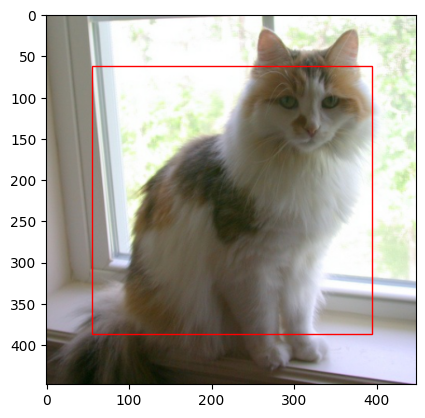

In [84]:
# for sample in test:
    # x = sample['img'].to(DEVICE)

    # for i in range(8):
bboxes = cellboxes_to_boxes(model(x))
bboxes = nms(bboxes[1], iou_threshold=0.5, threshold=0.4)
plot_test_img(x[1].permute(1,2,0).to("cpu"), bboxes)